### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeSaliencyLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [10]:
batch_size = 4 #受限于贫穷，4是极限了
learning_rate = 1e-7
target_size = 256
epochs = 1

In [11]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [12]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [13]:
model = VGG16()

In [14]:
model.load_state_dict(torch.load("./model/model_24.pth"), strict=False)

<All keys matched successfully>

In [15]:
model.eval()
model.to(device)
criterion = EdgeSaliencyLoss(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

In [16]:
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}".format(epoch + 1, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch + 1, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")

Epoch:1 loss:0.14994026720523834 Batch:100/2639 acc:0.9143456816673279 pre:0.8693129420280457 recall:0.9037280678749084 F-measure:0.8743436932563782
Epoch:1 loss:0.2269144505262375 Batch:200/2639 acc:0.9164314270019531 pre:0.8705147504806519 recall:0.9016942977905273 F-measure:0.8753792643547058
Epoch:1 loss:0.14594006538391113 Batch:300/2639 acc:0.9158986806869507 pre:0.8701484203338623 recall:0.8993903994560242 F-measure:0.8745498657226562
Epoch:1 loss:0.16014577448368073 Batch:400/2639 acc:0.9163792133331299 pre:0.8732889294624329 recall:0.9043334126472473 F-measure:0.8781684041023254
Epoch:1 loss:0.22591808438301086 Batch:500/2639 acc:0.9154097437858582 pre:0.8715997338294983 recall:0.902947187423706 F-measure:0.8764384388923645
Epoch:1 loss:0.17651191353797913 Batch:600/2639 acc:0.9152646064758301 pre:0.8705445528030396 recall:0.9044520258903503 F-measure:0.876002311706543
Epoch:1 loss:0.2062014490365982 Batch:700/2639 acc:0.9152309894561768 pre:0.8709701895713806 recall:0.9032816

In [17]:
torch.save(model.state_dict(),"./model/model_25.pth")

In [18]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [19]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [20]:
img = getInput("./image/1.jpg")

In [21]:
img.shape

torch.Size([3, 256, 256])

In [22]:
img = img.reshape(1, 3, 256, 256)
img = img.to(device)

In [23]:
predict = model(img)

In [24]:
predict.shape

torch.Size([1, 1, 256, 256])

In [25]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [26]:
msk.shape

torch.Size([256, 256, 1])

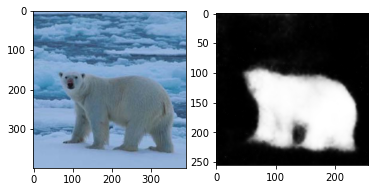

In [27]:
msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

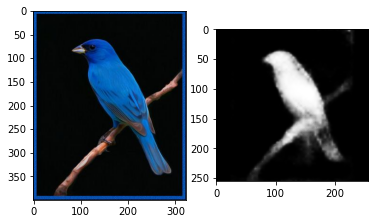

In [28]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

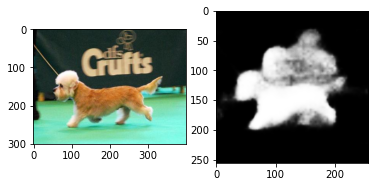

In [29]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

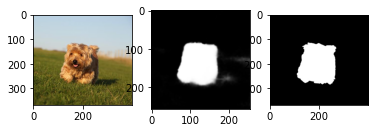

In [30]:
img = getInput("./DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(msk, cmap='gray')
plt.subplot(133)
plt.imshow(cv2.imread("./DUTS/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000004.png"))
plt.show()